참고 자료 :
* https://docs.nvidia.com/deeplearning/dali/user-guide/docs/index.html
* https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/getting%20started.html

# 1. 패키지 및 데이터 다운로드
* cuda version에 맞는 nvidia-dali 패키지를 설치합니다

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
!pip install torchvision
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist nvidia-dali-cuda110

Looking in indexes: https://pypi.org/simple, https://developer.download.nvidia.com/compute/redist
     |████████████████████████████████| 566.3MB 29kB/s 


* 간단한 classification 예제를 위해 flower dataset을 다운로드 합니다.
* flower dataset은 약 102개의 label이 있는 꽃 이미지 데이터 셋입니다.

In [ ]:
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip \
  && unzip -qq flower_data.zip

In [ ]:
import glob
!ls ./flower_data/

train  valid


# 2. Pipeline 작성
* DALI의 데이터 로더를 만들기 위해서 데이터 프로세싱 pipeline을 작성해야 합니다. 
* `pipeline_def` decorator를 이용하여 간단한 pipeline을 작성합니다.
  * `file_root` 디렉토리 아래에 `./<label_name>/<image_name.jpeg>` 와 같은 형식으로 저장되어있다면, `fn.readers.file` 을 통해 image 와 label을 읽을 수 있습니다.
  * `fn.decoders.image` 를 통해 jpeg image를 RGB로 decode 합니다.

In [ ]:
from nvidia.dali.pipeline import Pipeline
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
 
@pipeline_def
def simple_pipeline():
    image_dir = "./flower_data/train"
    jpegs, labels = fn.readers.file(file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device="cpu")
    return images, labels

* 위에서 작성한 `simple_pipeline` 의 인스턴스를 만들어 pipeline을 `build` 합니다
  * `batch_size` : batch size를 입력합니다.
  * `num_threads` : 계산에 사용할 cpu thread 개수를 입력합니다.
  * `device_id` : gpu를 같이 사용할 경우 device id를 할당합니다. (위 `simple_pipeline`은 gpu를 사용하지 않습니다.)
  * `seed` : random seed 를 지정합니다.

In [ ]:
pipe = simple_pipeline(batch_size=16, num_threads=1, device_id=0)
pipe.build()

* 한 번의 `run` 을 호출 할 때 마다, 한 batch에 해당하는 image 와 label을 받을 수 있습니다.
* `images` 와 `labels` 모두 `TensorListCPU` object 이므로, debugging을 위해 데이터를 확인하고 싶다면 numpy array로 변환해야 합니다.
* `is_dense_tensor`를 통해 변환이 가능한지 확인 후, `as_tensor` 메서드를 이용하여 변환하여 size를 확인합니다.

In [ ]:
images, labels = pipe.run()
print("images:", images.is_dense_tensor())
print("labels:", labels.is_dense_tensor())

images: False
labels: True


In [ ]:
import numpy as np
label_tensor = labels.as_tensor()
print("label size: {}".format(label_tensor.shape()))
print("label: {}".format(np.array(label_tensor)))

label size: [16, 1]
label: [[ 70]
 [ 44]
 [ 35]
 [ 90]
 [ 74]
 [ 89]
 [ 80]
 [ 71]
 [ 48]
 [ 76]
 [ 94]
 [ 99]
 [ 51]
 [ 23]
 [100]
 [ 77]]


* `TensorListCPU` 는 `at` 메서드를 통해 접근이 가능합니다.

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch, batch_size=16):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (8,(8 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

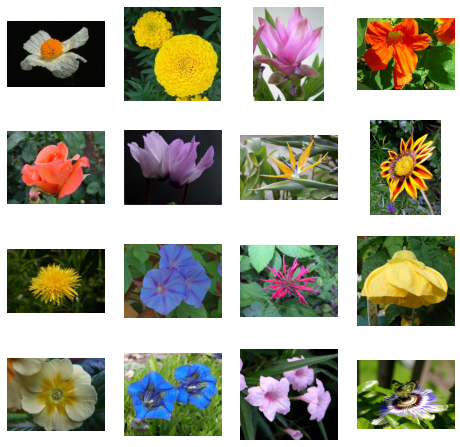

In [ ]:
show_images(images)

# 3. gpu 사용하기
* dali pipeline은 gpu를 사용하여 augmentation과 decoding 속도를 개선할 수 있습니다.
* 위에서 사용한 pipeline에서 `fn.resize`를 이용하여 입력 image의 x, y size를 224, 224로 변환하는 작업을 추가해보겠습니다.

## Pytorch Dataloader
비교를 위해 일반적으로 pytorch에서 가장 많이 사용하는 pytorch dataloder와 transform을 적용해보겠습니다.

### * Mission
**다양한 transforms 기법들을 추가하며 속도를 비교해봅시다**

In [ ]:
import random

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/supported_ops.html
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/image_processing/augmentation_gallery.html
dali_aug = {
    "normalize": lambda images: fn.normalize(images.gpu(), mean=0, stddev=255),
    "resize": lambda images: fn.resize(images, resize_x=224, resize_y=224),
    "horizontal_flip": lambda images: fn.flip(images, vertical=0, horizontal=1),
    "rotate": lambda images: fn.rotate(images, angle=30, interp_type=types.INTERP_LINEAR, fill_value=0)
}

torch_aug = transforms.Compose([
     transforms.ToTensor(),
     transforms.Resize((224, 224)),
     transforms.RandomHorizontalFlip(p=1),
     transforms.RandomRotation(30)
])

flower_dataset = ImageFolder("./flower_data/train", transform=torch_aug)

In [ ]:
@pipeline_def
def cpu_simple_pipeline():
    image_dir = "./flower_data/train"
    jpegs, labels = fn.readers.file(name="Reader", file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device="cpu")
    for aug in dali_aug.values():
      images = aug(images)
    return images, labels

* 작성한 pipeline의 augmentation 과정에서 gpu를 사용하는 방법은 간단합니다.
* `fn.resize` 에서 입력받는 image를 `image.gpu()` 로 변환하면 CPU 의 tensor를 GPU로 copy 하여 augmentation을 진행합니다.

In [ ]:
@pipeline_def
def gpu_simple_pipeline():
    image_dir = "./flower_data/train"
    jpegs, labels = fn.readers.file(name="Reader", file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device="cpu")
    for aug in dali_aug.values():
      images = aug(images)
    return images, labels.gpu()

* 고해상도의 image는 decode 과정에서 속도 저하가 생길 수 있습니다.
* 이때 `fn.decoders.image`의 `device`를 "mixed"로 설정하면 cpu와 gpu를 같이 사용하여 속도를 향상 시킬 수 있습니다.

In [ ]:
@pipeline_def
def mixed_simple_pipeline():
    image_dir = "./flower_data/train"
    jpegs, labels = fn.readers.file(name="Reader", file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device="mixed")
    for aug in dali_aug.values():
      images = aug(images)
    return images, labels.gpu()

* 위 세 종류의 데이터를 처리하는 pipeline 속도를 비교해보겠습니다.
* 20번 pipeline을 호출하여 1초당 처리하는 image 수를 출력하는 함수를 작성합니다.

In [ ]:
import torch
from timeit import default_timer as timer

def speedtest(pipeline, batch=64, n_threads=4):
    pipe = pipeline(batch_size=batch, num_threads=n_threads, device_id=0)
    pipe.build()
    # warmup
    for i in range(5):
        pipe.run()
    # test
    n_test = 30
    t_start = timer()
    for i in range(n_test):
        pipe.run()
    t = timer() - t_start
    print(f"Elapsed: {t:.2f} s, Speed: {n_test * batch/t:.2f} imgs/s")
  
def pytorch_speedtest(ds, batch=64, n_threads=4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch_dataloader = DataLoader(
      ds, batch_size=batch, shuffle=True, num_workers=n_threads, pin_memory=True)
    it = iter(torch_dataloader)
    # warm up
    for i in range(5):
      img, label = next(it)
      img, label = img.to(device), label.to(device)
    n_test = 30
    t_start = timer()
    for i in range(n_test):
      img, label = next(it)
      img, label = img.to(device), label.to(device)
    t = timer() - t_start
    print(f"Elapsed: {t:.2f} s, Speed: {n_test * batch/t:.2f} imgs/s")

기존 pytorch dataloader와 비교하여, 세 방법 모두 속도가 개선됨을 확인할 수 있고,
세 pipeline(cpu, gpu, mixed)를 비교했을 때 점진적으로 속도가 향상되는 것을 확인 할 수 있습니다.

In [ ]:
print("cpu_simple_pipeline")
speedtest(cpu_simple_pipeline, batch=64, n_threads=4)

cpu_simple_pipeline
Elapsed: 2.48 s, Speed: 774.66 imgs/s


In [ ]:
print("gpu_simple_pipeline")
speedtest(gpu_simple_pipeline, batch=64, n_threads=4)

gpu_simple_pipeline
Elapsed: 2.48 s, Speed: 774.50 imgs/s


In [ ]:
print("mixed_simple_pipeline")
speedtest(mixed_simple_pipeline, batch=64, n_threads=4)

mixed_simple_pipeline
Elapsed: 1.13 s, Speed: 1697.44 imgs/s


In [ ]:
print("pytorch dataloader")
pytorch_speedtest(flower_dataset, batch=64, n_threads=4)

pytorch dataloader


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Elapsed: 23.93 s, Speed: 80.22 imgs/s


### Augmentation 확인하기

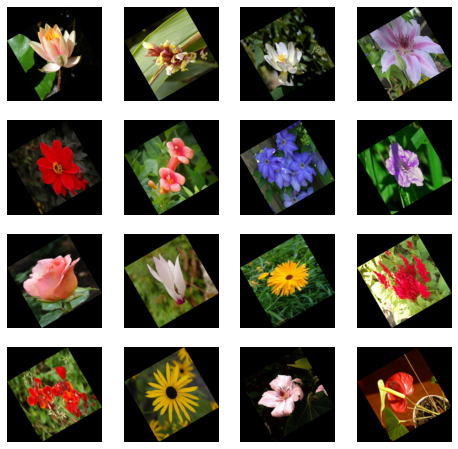

In [ ]:
pipe = mixed_simple_pipeline(batch_size=16, num_threads=1, device_id=0)
pipe.build()
images, labels = pipe.run()
show_images(images.as_cpu())

# 4. Model 학습하기
* flower dataset을 분류하는 간단한 CNN 모델을 작성합니다.
* 동일한 augmentation을 사용하는 기존 torch dataloader와 dali pipeline을 각각 작성하여 학습해보고, 속도를 비교해보겠습니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class MyModel(nn.Module):
    def __init__(self, model_conv, label=102):
        super().__init__()
        self.model_ft = model_conv
        num_ftrs = self.model_ft.fc.in_features
        self.model_ft.fc = nn.Linear(num_ftrs, label) # create layer

    def forward(self, x):
        return self.model_ft(x)

def create_model():
  model_conv = models.resnet18(pretrained=True)
  for param in model_conv.parameters():
      param.requires_grad = False
  return MyModel(model_conv)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model creation test
test_model = create_model().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


* 위 예제와 동일하게 `pipeline_def`를 이용하여 pipeline을 작성합니다.
* 기존 torchvision의 `transforms.ToTensor`이 `[0,255]`인 image pixel 값을 255로 나누어 `[0,1]` 값으로 출력하듯이, 
dali의 `fn.normalize`에 `mean=0, sttdev=255`를 적용하여 동일하게 255로 나누어주는 작업을 추가합니다.
$$ input_{normalized} = (input - mean) / stddev$$

### * Mission
**위에서 시도해본 다양한 transform을 이용하여 학습을 진행한 후 시간을 비교해봅시다**

In [ ]:
# Dali loader
@pipeline_def
def dali_mixed_pipeline():
    image_dir = "./flower_data/train"
    jpegs, labels = fn.readers.file(name="Reader", file_root=image_dir, random_shuffle=True)
    images = fn.decoders.image(jpegs, device="mixed")
    images= fn.normalize(images.gpu(), mean=0, stddev=255)  # same as divide by 255
    images = fn.resize(images.gpu(), resize_x=224, resize_y=224)
    return images, labels.gpu()

torch_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224, 224)),
])

* `torch_simpe_pipeline`을 `build` 합니다

In [ ]:
batch_size=32
num_threads=4
pipe = dali_mixed_pipeline(batch_size=32,num_threads=4,device_id=0)
pipe.build()

* dali 에서는 torch dataloader 처럼 pytorch의 tensor 형식으로 iterator의 결과를 출력하도록 하는 `DALIGenericIterator`를 지원합니다.
  * `pipelines` : 사용할 pipeline 을 입력합니다.
  * `output_map` : pipline에서 출력하는 output을 key로 접근하기 위한 이름을 mapping 합니다.
  * `size` : pipeline의 데이터 sample 수 입니다. `pipe`의 `epoch_size`를 통해 1 epoch에 해당하는 sample 수를 입력할 수 있습니다.
  * `last_batch_policy` : 마지막 batch에 대한 policy를 지정합니다. LastBatchPolicy.Partial로 지정하는 경우 마지막 batch가 지정한 batch_size 보다 작을 경우, 남은 batch를 그대로 return 합니다.
  * `auto_reset` : 다음 epoch에 대해 iterator를 reset 합니다. 

In [ ]:
from nvidia.dali.plugin.pytorch import DALIGenericIterator, LastBatchPolicy

dali_dl = DALIGenericIterator(
  pipelines=pipe, 
  output_map=['image', 'label'], 
  size=pipe.epoch_size("Reader"), 
  last_batch_padded=True,
  last_batch_policy=LastBatchPolicy.PARTIAL, 
  auto_reset=True
)

torch_dl = DataLoader(
  flower_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads, pin_memory=True
)
torch_dl.dataset.transform = torch_transform

/usr/local/lib/python3.7/dist-packages/nvidia/dali/plugin/base_iterator.py:162: Warning: Please set `reader_name` and don't set last_batch_padded and size manually whenever possible. This may lead, in some situations, to missing some samples or returning duplicated ones. Check the Sharding section of the documentation for more details.
  _iterator_deprecation_warning()
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* 모델을 학습하는 코드를 작성합니다.
  * pipeline의 iterator 출력인 `image` 의 차원이 `(batch_size, height, width, channel)`
   이므로, model의 입력에 맞게 `(batch_size, channel, height, width)` 로 수정합니다.
  * `label` 의 자료형을 `long` 에 맞게 변환합니다.

In [ ]:
import time

def train(dl, model, num_epochs=5):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters())

  start = time.time()
  for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dl):
      # DALI
      if type(dl) == DALIGenericIterator:
        inputs = data[0]["image"].permute(0, 3, 1, 2).to(device)
        labels = data[0]["label"].long().view(-1).to(device)
      # Torch
      else:
        inputs, labels = data[0].to(device), data[1].to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      
    print('epoch : %d loss: %.3f' %(epoch + 1, running_loss / (i+1)))
  print('Finished Training')
  print(np.round(time.time() - start, 2), '(seconds)')

@torch.no_grad()
def test(dl, model):
  start = time.time()
  correct = 0
  total = 0
  for i, data in enumerate(dl):
    # DALI
    if type(dl) == DALIGenericIterator:
      inputs = data[0]["image"].permute(0, 3, 1, 2).to(device)
      labels = data[0]["label"].long().view(-1).to(device)
    # Torch
    else:
      inputs, labels = data[0].to(device), data[1].to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    correct += (preds == labels).sum()
    total += labels.shape[0]
  print(f"Acc: {correct/total*100.0:.2f}%")
  print(f"Elapsed time: {(time.time() - start):.2f} sec")


In [ ]:
# Train
print("DALI")
dali_model = create_model().to(device)
train(dali_dl, dali_model)
print("Torch")
torch_model = create_model().to(device)
train(torch_dl, torch_model)

DALI
epoch : 1 loss: 2.590
epoch : 2 loss: 0.892
epoch : 3 loss: 0.543
epoch : 4 loss: 0.389
epoch : 5 loss: 0.294
Finished Training
196.91 (seconds)
Torch


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch : 1 loss: 2.669
epoch : 2 loss: 0.916
epoch : 3 loss: 0.551
epoch : 4 loss: 0.398
epoch : 5 loss: 0.307
Finished Training
233.61 (seconds)


In [ ]:
# Test
test(dali_dl, dali_model)
test(torch_dl, torch_model)

Acc: 96.37%
Elapsed time: 38.15 sec


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Acc: 96.05%
Elapsed time: 48.09 sec


* 위 pipeline의 data processing 과정과 동일하게 일반적인 torch dataloader를 작성합니다.
  * `transforms.ToTensor`를 통해 pixel 값을 255로 나눈 후 torch tensor 형식으로 변환합니다.
  * `transforms.Resize`를 통해 높이를 224, 넓이를 224로 Resize 합니다.

* `DataLoader`를 만들고 동일한 모델을 학습시킵니다